### Project Setup

In [2429]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2430]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [2431]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [2432]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

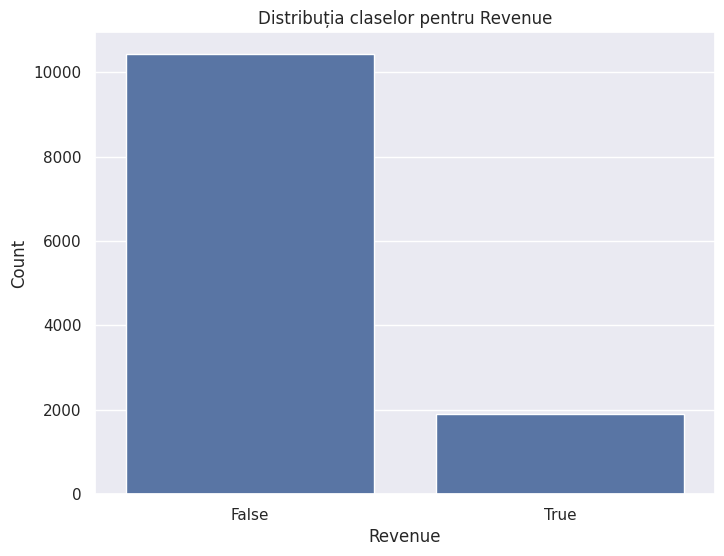

In [2433]:
# Verificarea echilibrului claselor
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

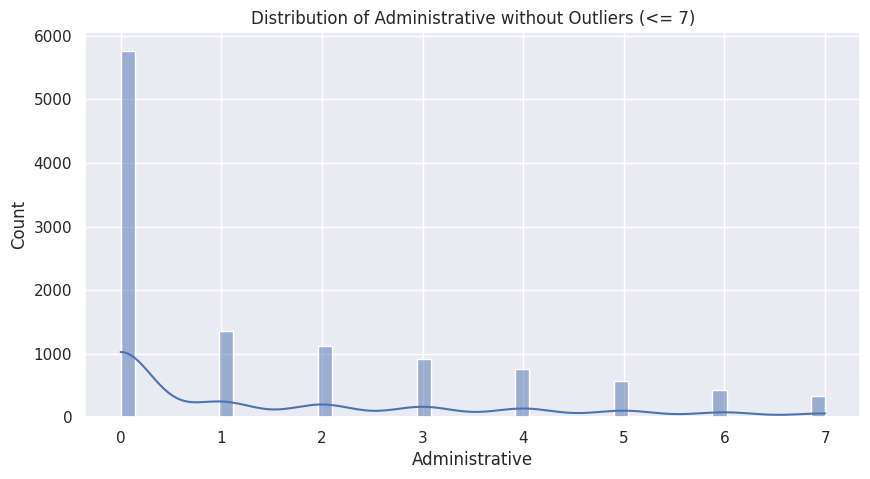

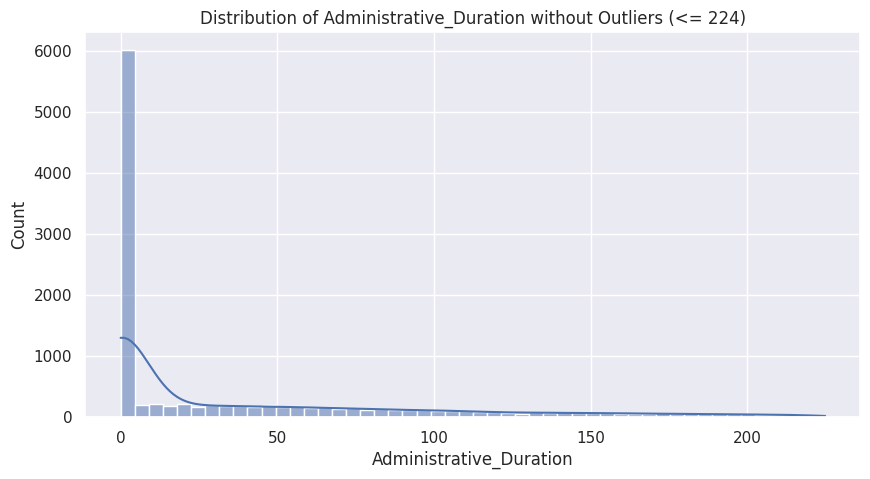

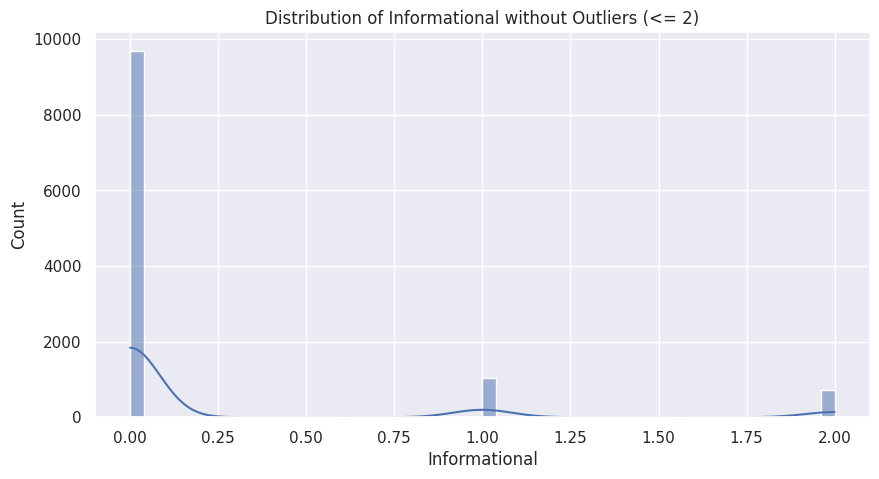

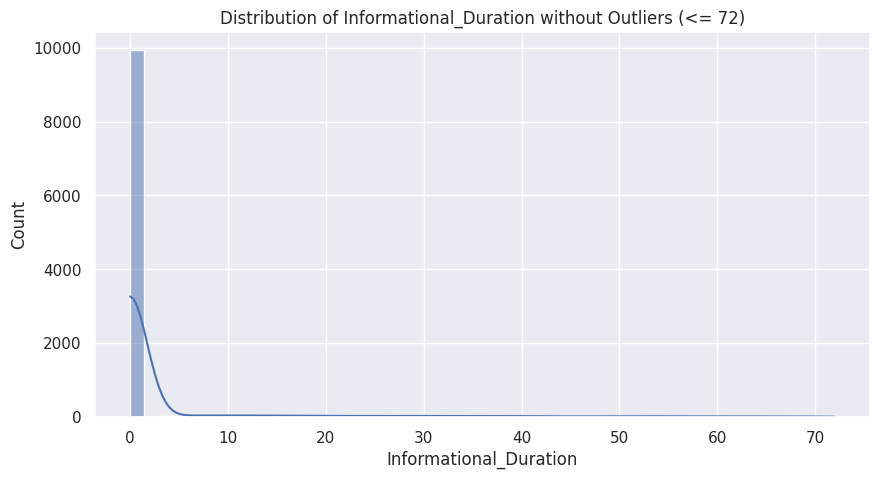

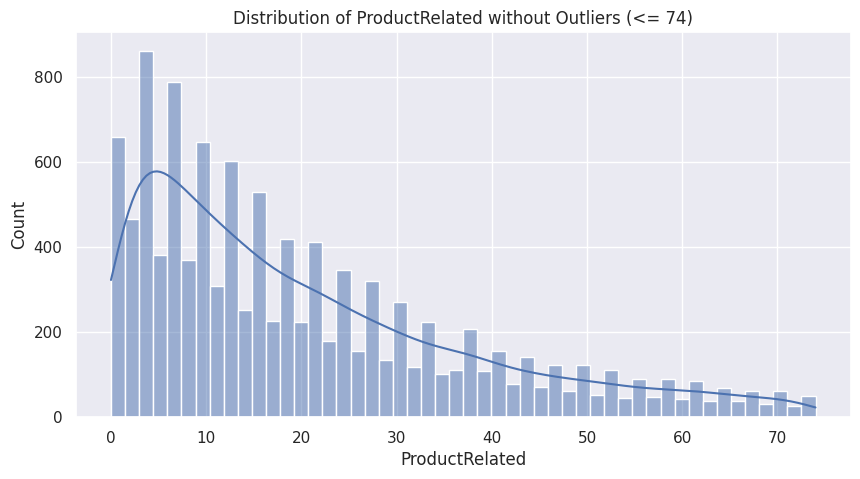

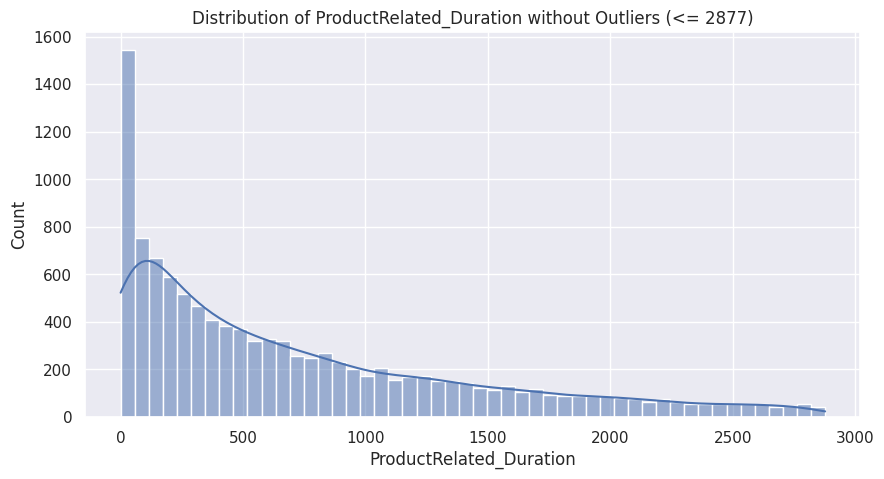

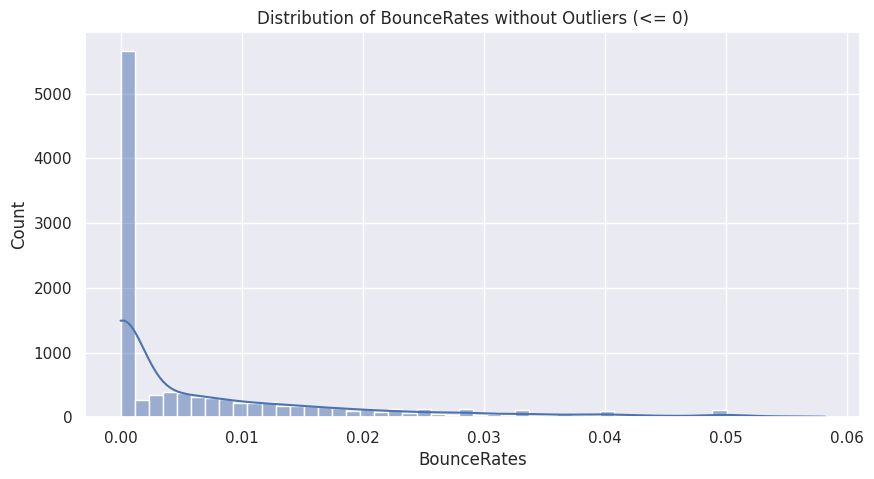

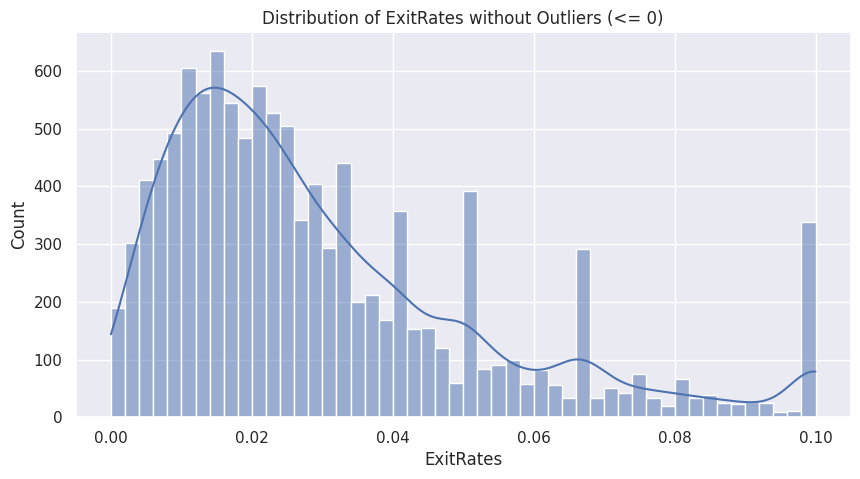

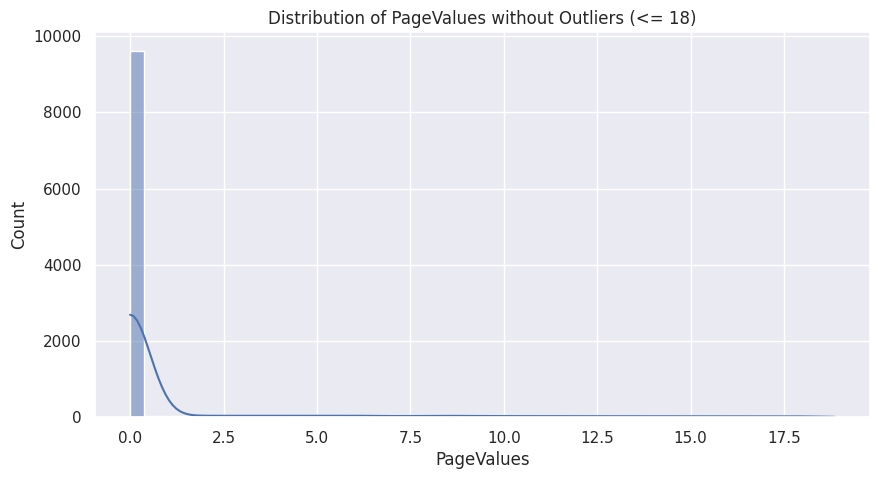

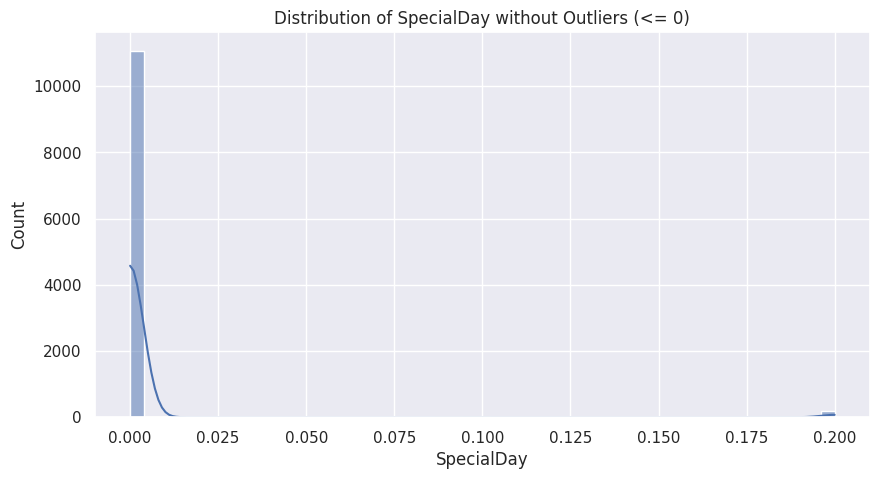

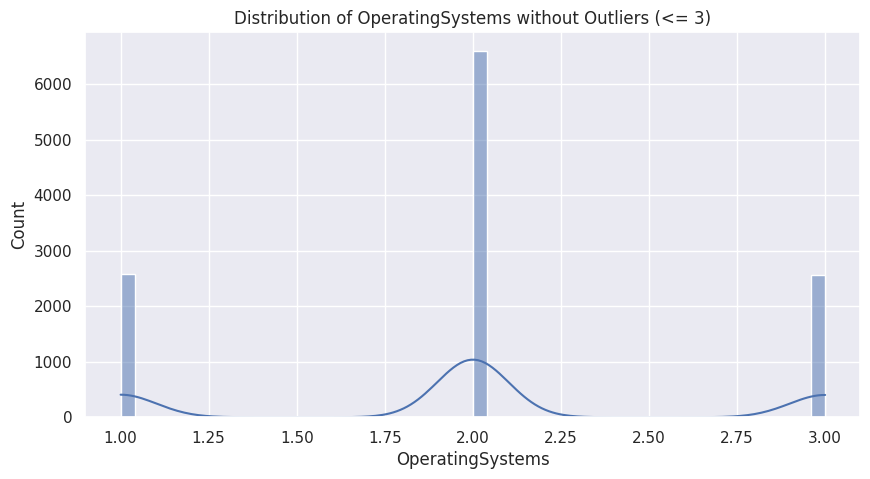

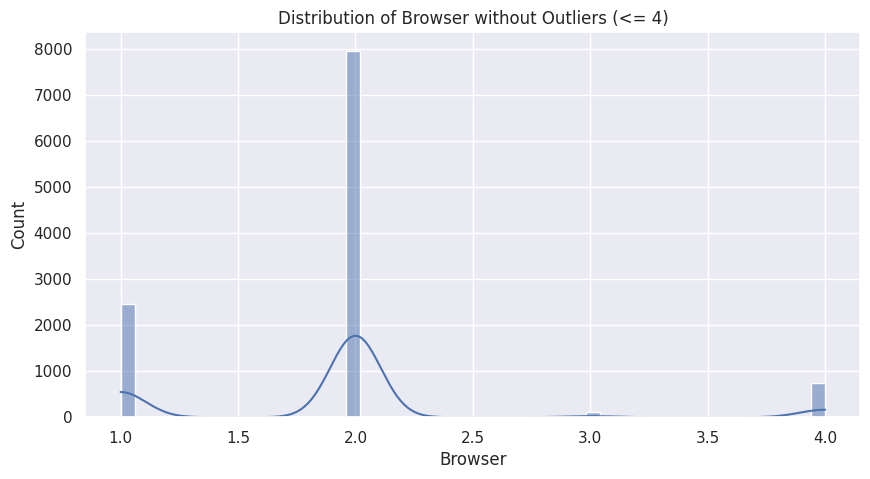

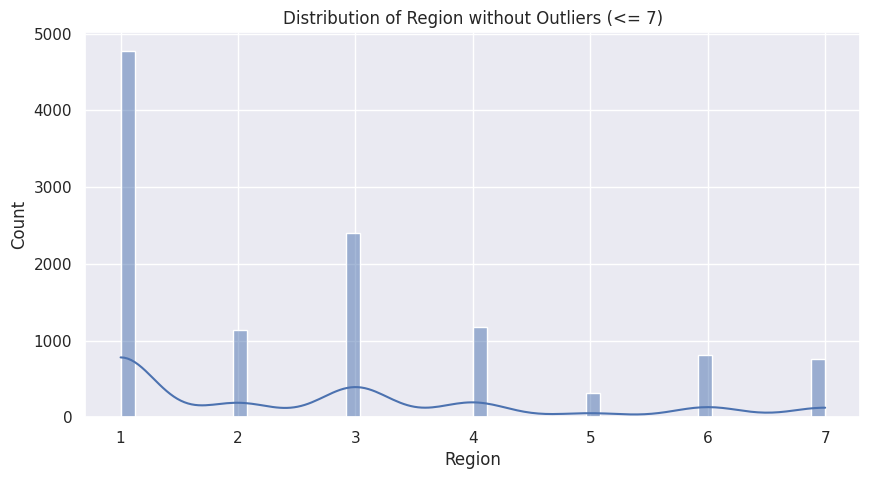

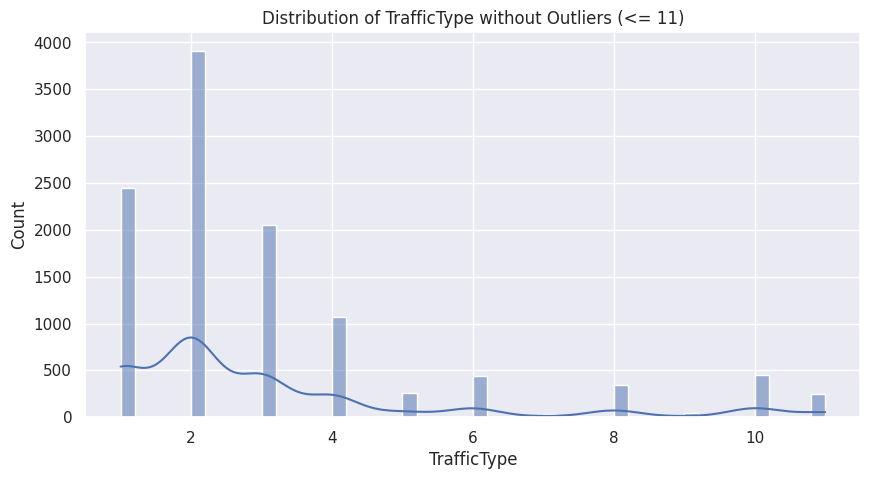

In [2434]:
# Identificarea atributelor numerice
numeric_features = df.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    # Calculați percentilele cu granularitate de 10%
    percentiles = np.percentile(df[feature], np.arange(0, 101, 10))
    
    # Alegem pragul pentru a elimina outlierii (de exemplu, 90th percentile)
    threshold = percentiles[9]
    
    # Filtrați datele pentru a elimina outlierii
    filtered_data = df[df[feature] <= threshold]
    
    # Realizați un grafic pentru distribuția valorilor fără outlieri
    plt.figure(figsize=(10, 5))
    sns.histplot(filtered_data[feature], bins=50, kde=True)
    
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} without Outliers (<= {int(threshold)})')
    plt.show()

### 2.A Atribute Categorice

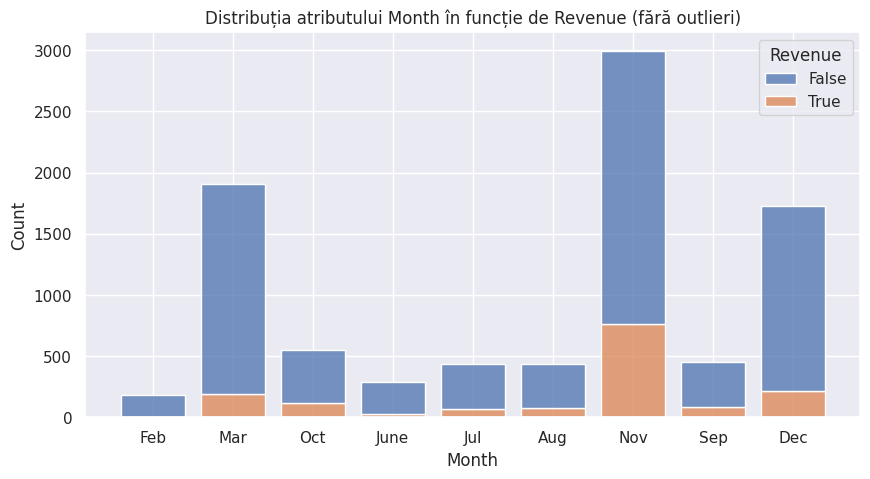

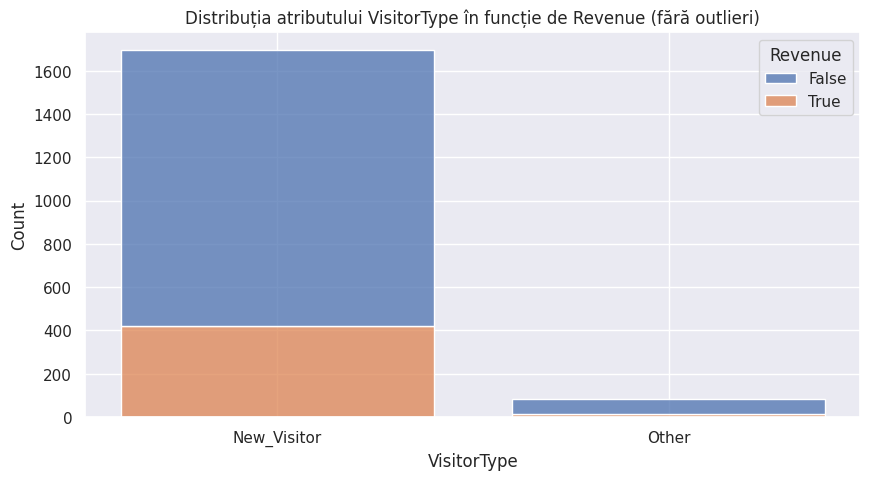

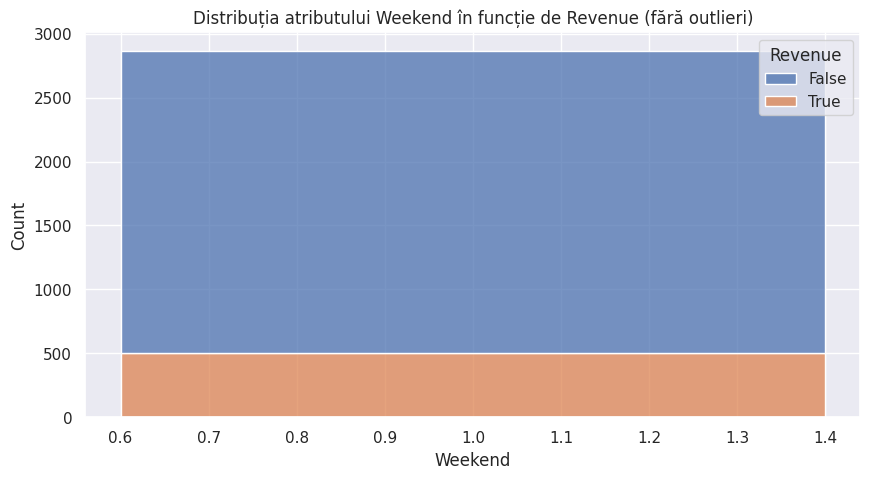

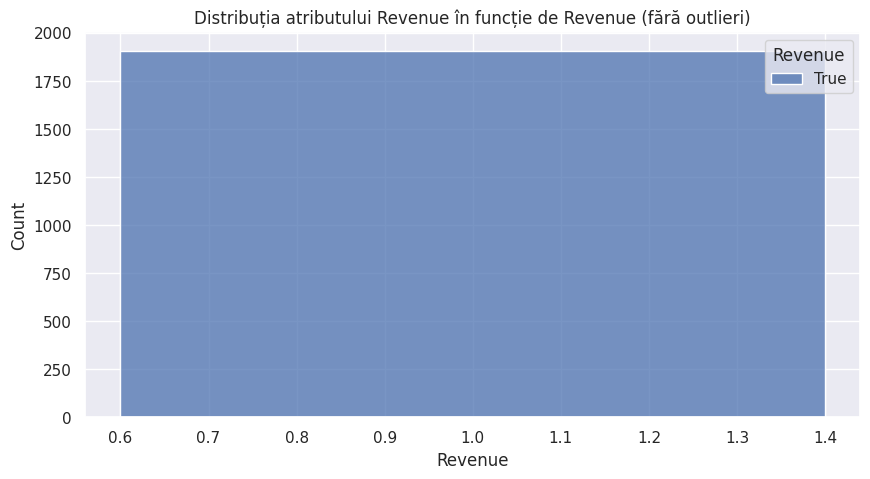

In [2435]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

for attribute in categorical_attributes:
    # Calculăm frecvența pentru fiecare categorie
    category_counts = df[attribute].value_counts()

    # Alegem un prag pentru a elimina categoriile cu o frecvență mai mare decât percentilele specificate (de exemplu, 90th percentile)
    threshold = np.percentile(category_counts, 90)

    # Filtrăm datele pentru a păstra doar categoriile cu frecvență sub prag
    df_filtered = df[df[attribute].isin(category_counts[category_counts <= threshold].index)]

    # Realizăm un grafic pentru distribuția categoriilor după eliminarea outlierilor
    plt.figure(figsize=(10, 5))
    sns.histplot(x=attribute, data=df_filtered, hue='Revenue', multiple='stack', shrink=0.8)
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue (fără outlieri)')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




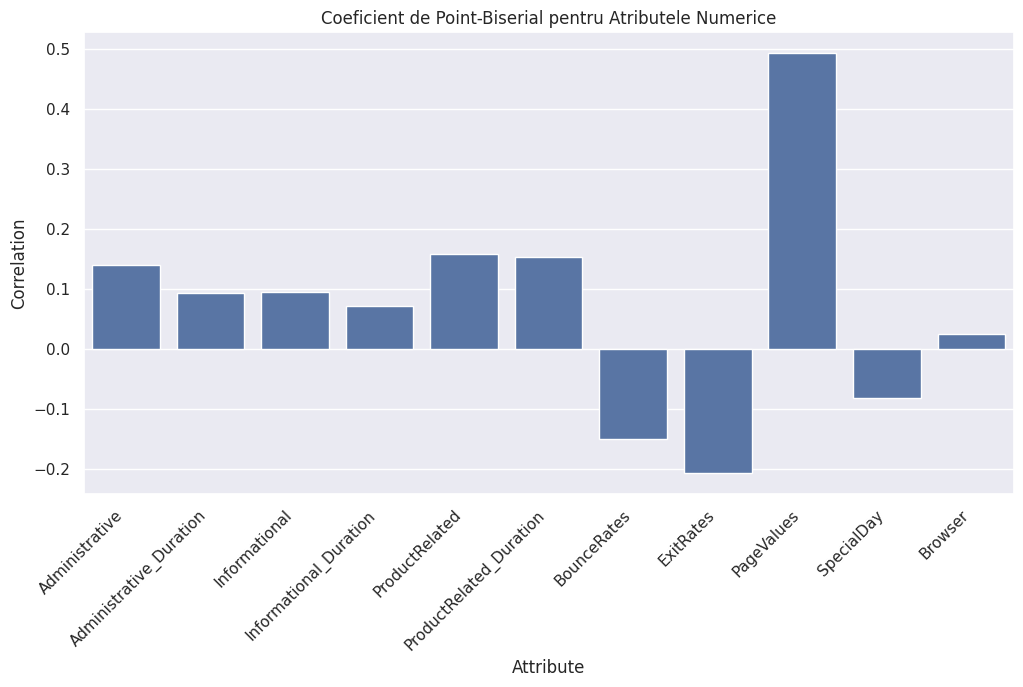

In [2436]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




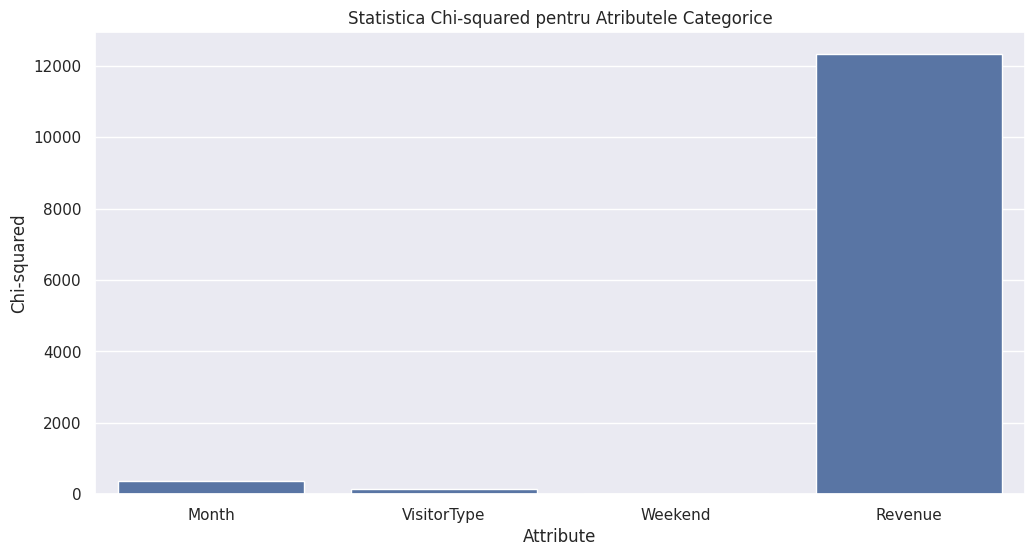

In [2437]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


### Concluzia analizei p-value folosind Coeficientul de Point-Biserial si Testul Chi-squared
- Un p-value cat mai mic indica o corelare mai mare a atributului cu tinta de predictie
- Vom folosi p-valiue <= 0.05 ca valoare maxima admisibila pentru un atribut, pentru a-l considera relrevant in predictia noastra

# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [2438]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [2439]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [2440]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [2441]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [2442]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [2443]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [2444]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

In [2445]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    # Modify the dataset to include only the features we consider relevant to our target
    # Lista cu numele caracteristicilor selectate pe baza p-value-ului
    selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                     'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                     'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 'VisitorType', 'Weekend']
    X_selected = X[selected_features]
    
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.6759935117599352
Precision folosind MinMaxScaler: 0.09251968503937008
Recall folosind MinMaxScaler: 0.12207792207792208
F1 Score folosind MinMaxScaler: 0.10526315789473685


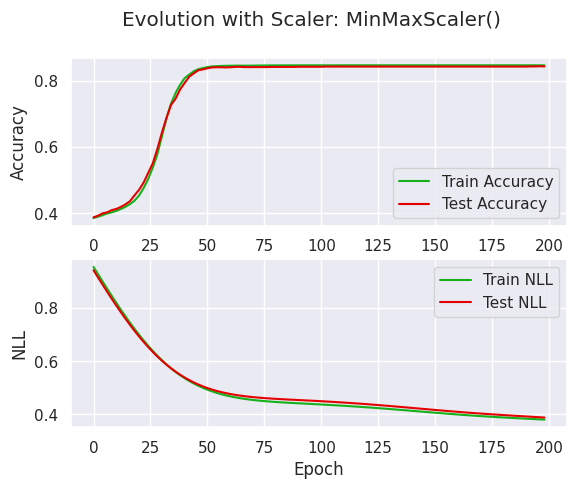

Acuratete folosind StandardScaler: 0.32278994322789945
Precision folosind StandardScaler: 0.049408489909533754
Recall folosind StandardScaler: 0.18933333333333333
F1 Score folosind StandardScaler: 0.0783664459161148


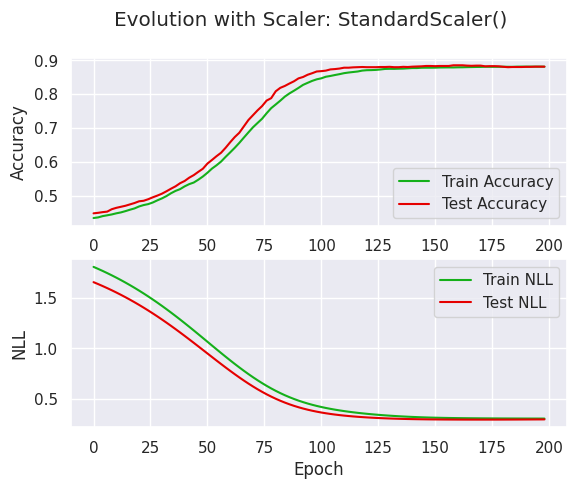

Acuratete folosind RobustScaler: 0.6707218167072182
Precision folosind RobustScaler: 0.07554671968190854
Recall folosind RobustScaler: 0.0987012987012987
F1 Score folosind RobustScaler: 0.08558558558558559


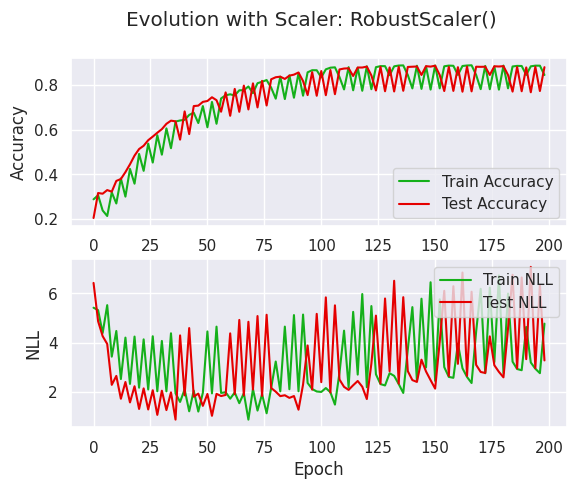


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.49635036496350365
Precision folosind MinMaxScaler: 0.06506506506506507
Recall folosind MinMaxScaler: 0.1742627345844504
F1 Score folosind MinMaxScaler: 0.09475218658892129


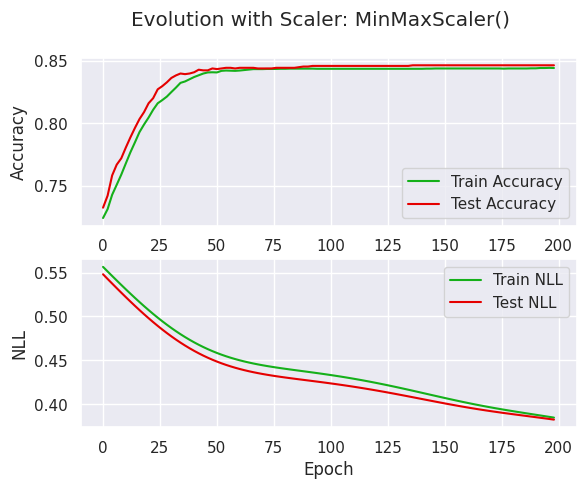

Acuratete folosind StandardScaler: 0.3357664233576642
Precision folosind StandardScaler: 0.06929347826086957
Recall folosind StandardScaler: 0.2756756756756757
F1 Score folosind StandardScaler: 0.11074918566775244


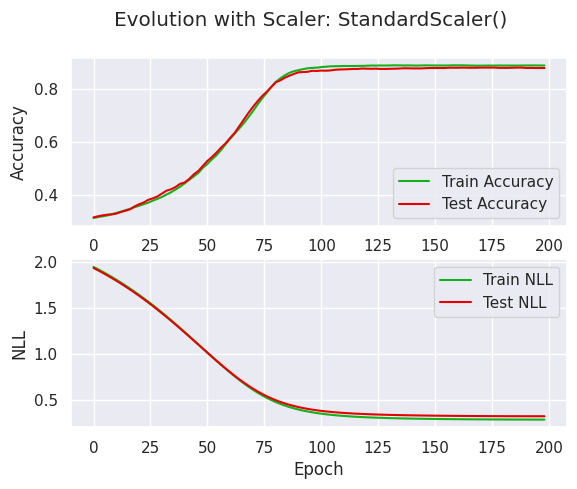

Acuratete folosind RobustScaler: 0.47039740470397406
Precision folosind RobustScaler: 0.10045248868778281
Recall folosind RobustScaler: 0.2624113475177305
F1 Score folosind RobustScaler: 0.14528795811518322


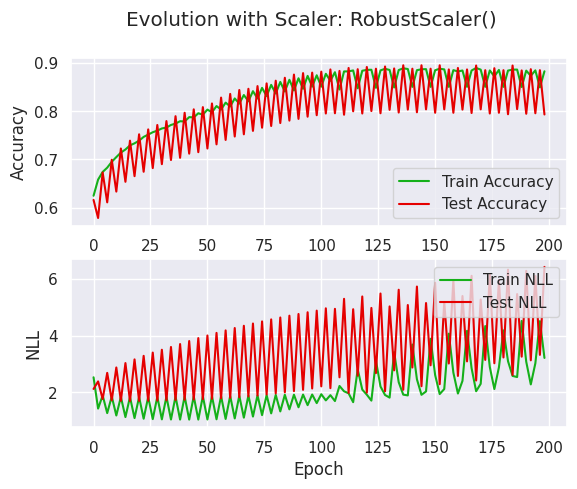


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.8130575831305759
Precision folosind MinMaxScaler: 0.0958904109589041
Recall folosind MinMaxScaler: 0.017412935323383085
F1 Score folosind MinMaxScaler: 0.029473684210526315


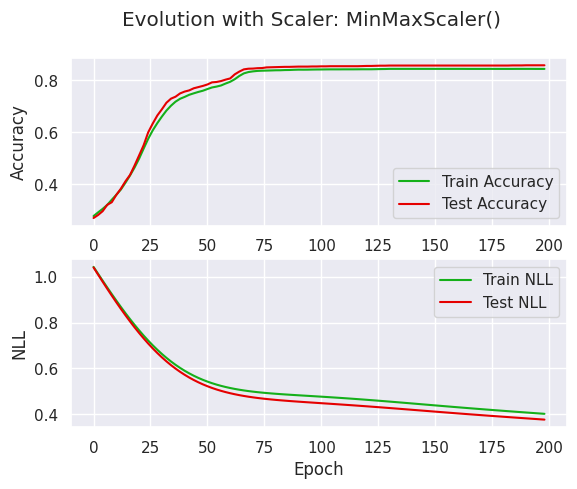

Acuratete folosind StandardScaler: 0.3353609083536091
Precision folosind StandardScaler: 0.061068702290076333
Recall folosind StandardScaler: 0.23529411764705882
F1 Score folosind StandardScaler: 0.09696969696969697


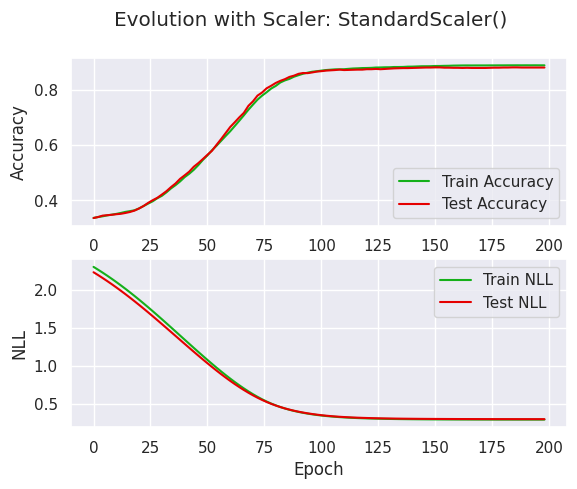

Acuratete folosind RobustScaler: 0.6723438767234388
Precision folosind RobustScaler: 0.23950617283950618
Recall folosind RobustScaler: 0.5025906735751295
F1 Score folosind RobustScaler: 0.32441471571906355


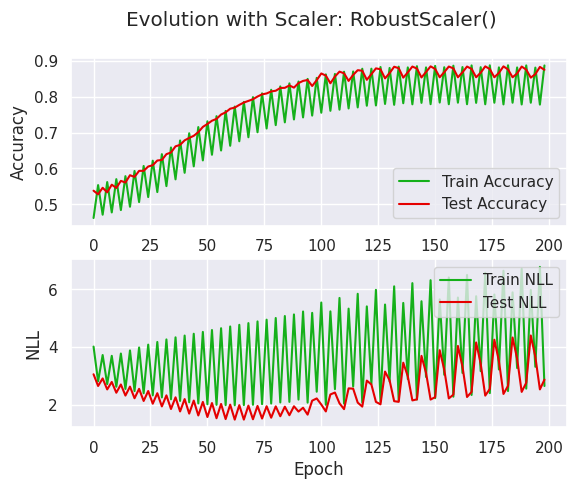


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.8122465531224655
Precision folosind MinMaxScaler: 0.056818181818181816
Recall folosind MinMaxScaler: 0.012987012987012988
F1 Score folosind MinMaxScaler: 0.021141649048625793


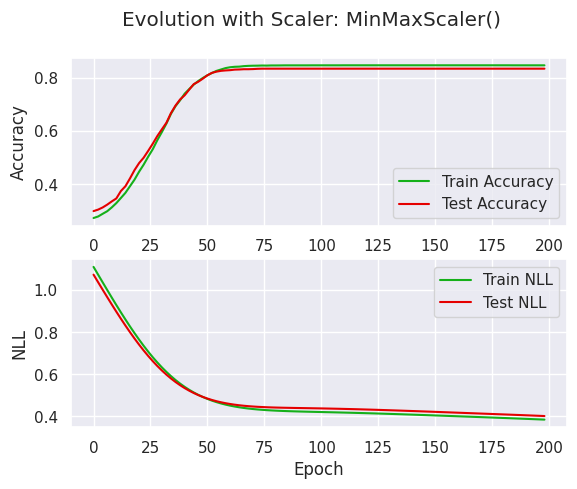

Acuratete folosind StandardScaler: 0.4148418491484185
Precision folosind StandardScaler: 0.1204644412191582
Recall folosind StandardScaler: 0.4181360201511335
F1 Score folosind StandardScaler: 0.18704225352112674


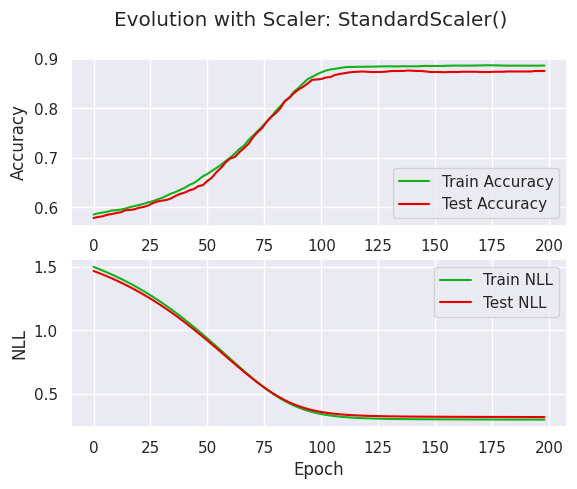

Acuratete folosind RobustScaler: 0.6017842660178426
Precision folosind RobustScaler: 0.1353811149032992
Recall folosind RobustScaler: 0.3489736070381232
F1 Score folosind RobustScaler: 0.19508196721311477


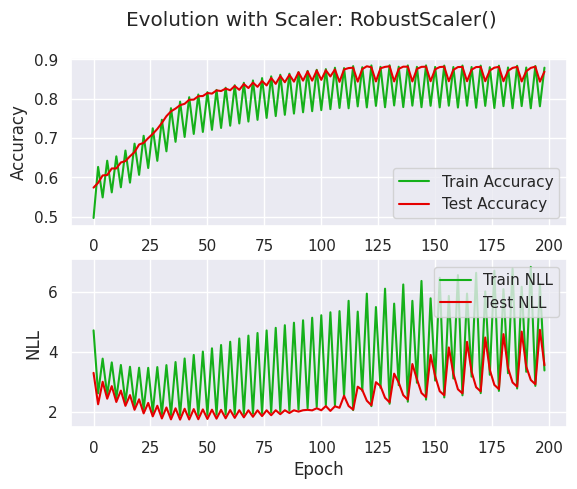


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.7688564476885644
Precision folosind MinMaxScaler: 0.06726457399103139
Recall folosind MinMaxScaler: 0.03978779840848806
F1 Score folosind MinMaxScaler: 0.049999999999999996


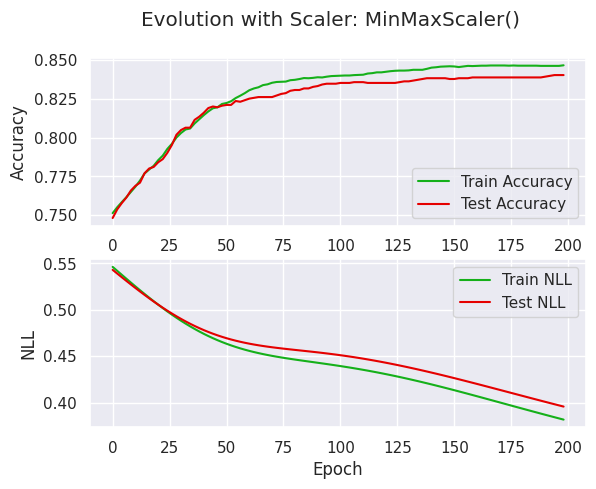

Acuratete folosind StandardScaler: 0.3175182481751825
Precision folosind StandardScaler: 0.0515818431911967
Recall folosind StandardScaler: 0.19788918205804748
F1 Score folosind StandardScaler: 0.0818330605564648


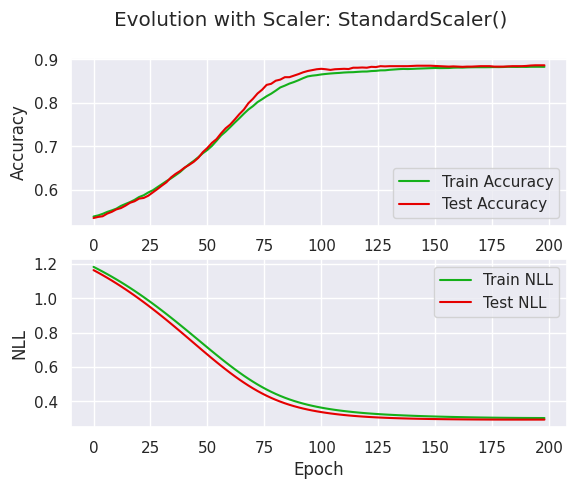

Acuratete folosind RobustScaler: 0.47364152473641524
Precision folosind RobustScaler: 0.025380710659898477
Recall folosind RobustScaler: 0.06887052341597796
F1 Score folosind RobustScaler: 0.0370919881305638


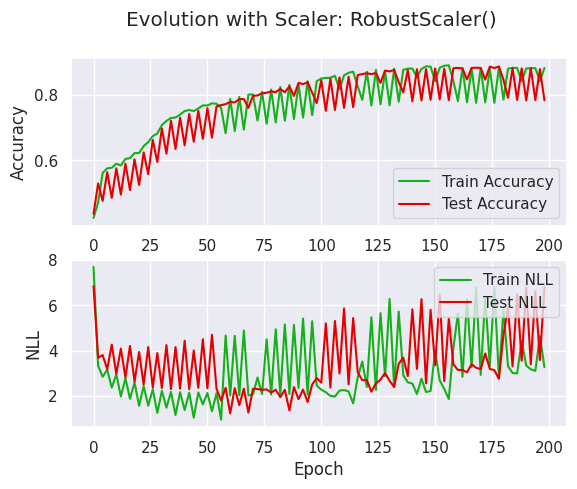


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.8021086780210868
Precision folosind MinMaxScaler: 0.1297709923664122
Recall folosind MinMaxScaler: 0.043478260869565216
F1 Score folosind MinMaxScaler: 0.06513409961685823


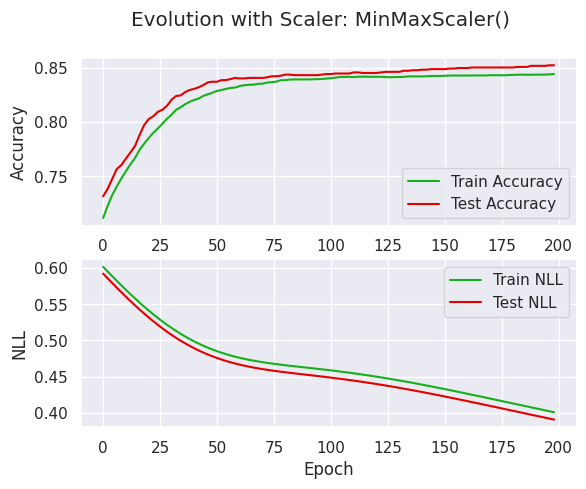

Acuratete folosind StandardScaler: 0.3329278183292782
Precision folosind StandardScaler: 0.059233449477351915
Recall folosind StandardScaler: 0.2236842105263158
F1 Score folosind StandardScaler: 0.09366391184573003


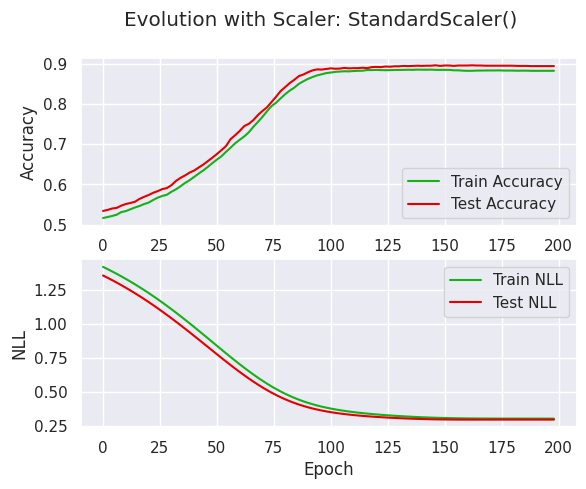

Acuratete folosind RobustScaler: 0.46877534468775345
Precision folosind RobustScaler: 0.019895287958115182
Recall folosind RobustScaler: 0.04834605597964377
F1 Score folosind RobustScaler: 0.028189910979228485


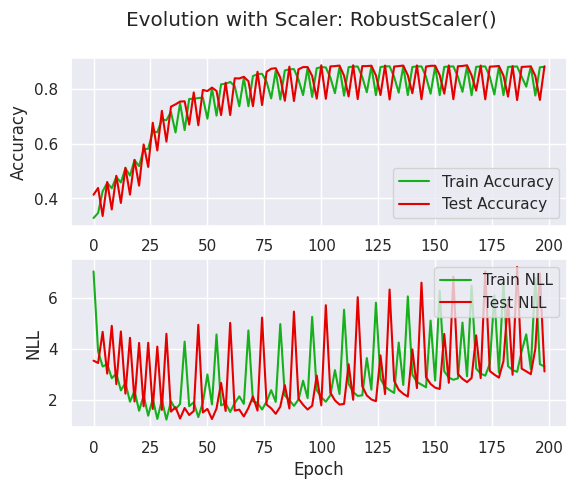


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.8438767234387672
Precision folosind MinMaxScaler: 0.3333333333333333
Recall folosind MinMaxScaler: 0.010498687664041995
F1 Score folosind MinMaxScaler: 0.02035623409669211


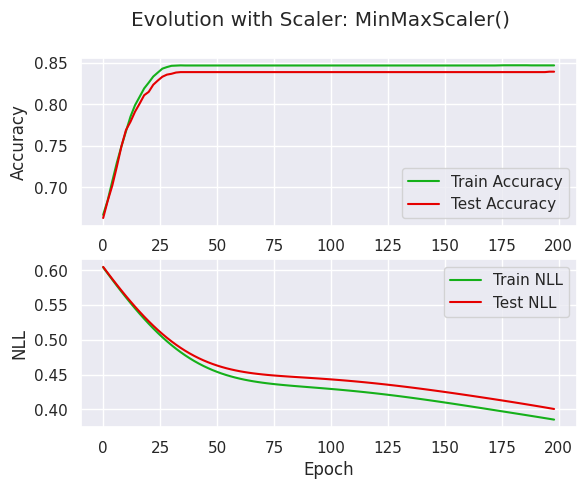

Acuratete folosind StandardScaler: 0.3734793187347932
Precision folosind StandardScaler: 0.10236768802228412
Recall folosind StandardScaler: 0.36476426799007444
F1 Score folosind StandardScaler: 0.1598694942903752


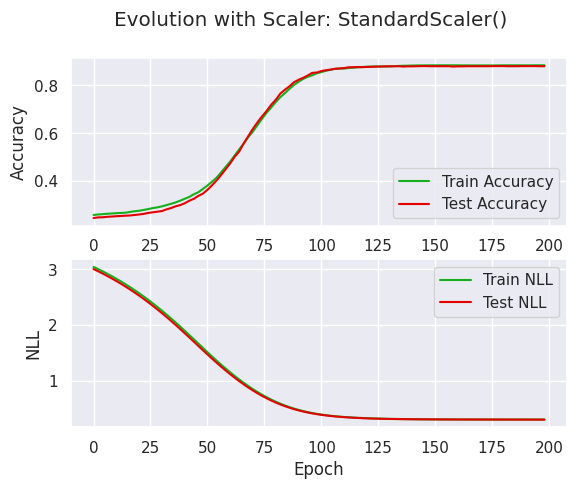

Acuratete folosind RobustScaler: 0.48337388483373883
Precision folosind RobustScaler: 0.02889576883384933
Recall folosind RobustScaler: 0.07756232686980609
F1 Score folosind RobustScaler: 0.042105263157894736


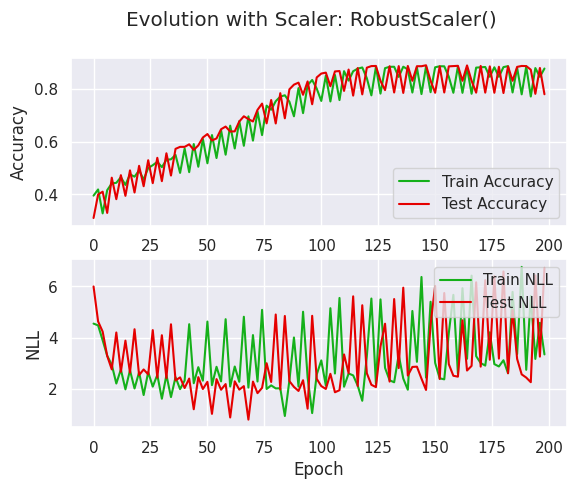


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.7960259529602596
Precision folosind MinMaxScaler: 0.10869565217391304
Recall folosind MinMaxScaler: 0.0379746835443038
F1 Score folosind MinMaxScaler: 0.056285178236397754


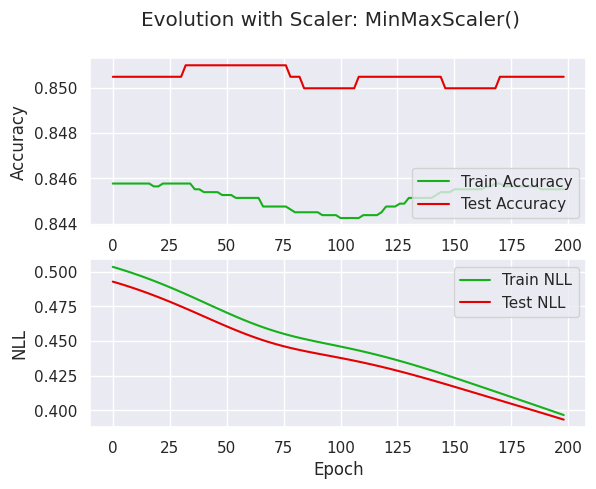

Acuratete folosind StandardScaler: 0.3313057583130576
Precision folosind StandardScaler: 0.06639566395663957
Recall folosind StandardScaler: 0.26558265582655827
F1 Score folosind StandardScaler: 0.10623306233062332


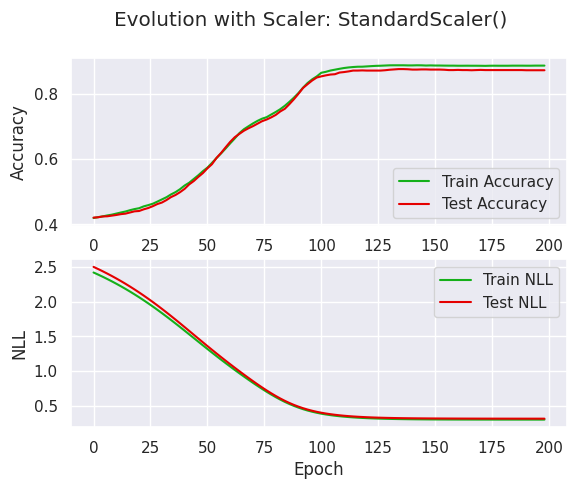

Acuratete folosind RobustScaler: 0.45944849959448497
Precision folosind RobustScaler: 0.035748792270531404
Recall folosind RobustScaler: 0.09946236559139784
F1 Score folosind RobustScaler: 0.052594171997157074


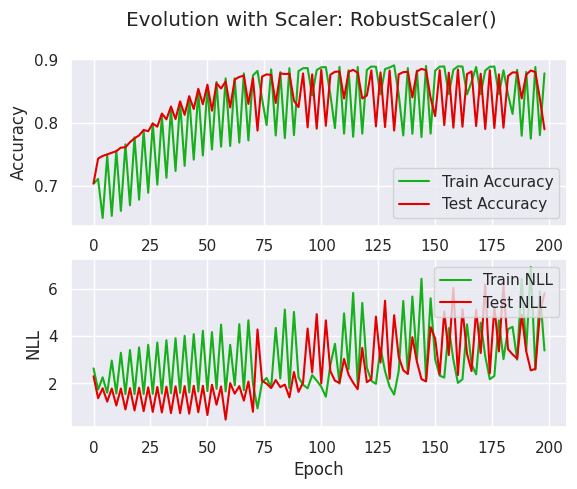


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.6832927818329279
Precision folosind MinMaxScaler: 0.12750455373406194
Recall folosind MinMaxScaler: 0.1881720430107527
F1 Score folosind MinMaxScaler: 0.15200868621064062


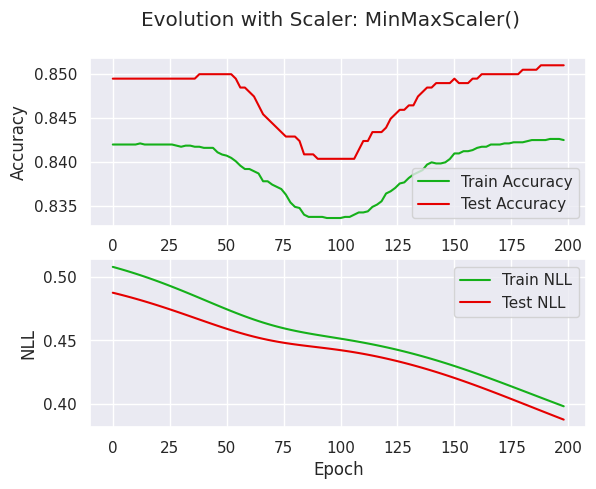

Acuratete folosind StandardScaler: 0.4233576642335766
Precision folosind StandardScaler: 0.12780898876404495
Recall folosind StandardScaler: 0.5027624309392266
F1 Score folosind StandardScaler: 0.20380739081746924


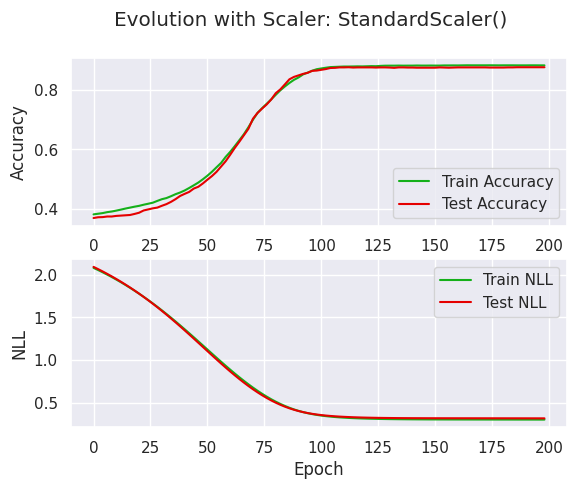

Acuratete folosind RobustScaler: 0.4845904298459043
Precision folosind RobustScaler: 0.04536290322580645
Recall folosind RobustScaler: 0.12195121951219512
F1 Score folosind RobustScaler: 0.06612784717119766


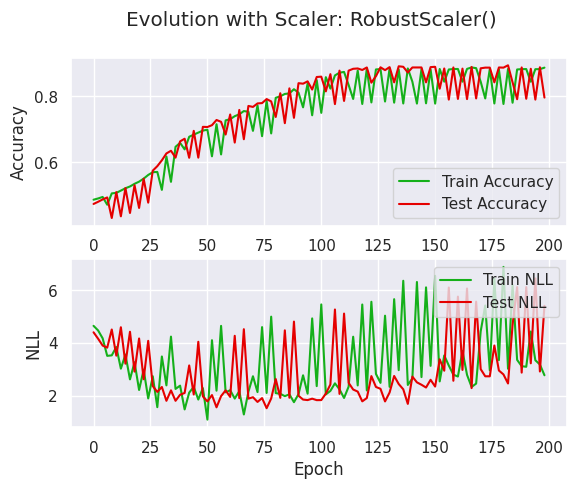


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.8142741281427412
Precision folosind MinMaxScaler: 0.18181818181818182
Recall folosind MinMaxScaler: 0.05154639175257732
F1 Score folosind MinMaxScaler: 0.08032128514056225


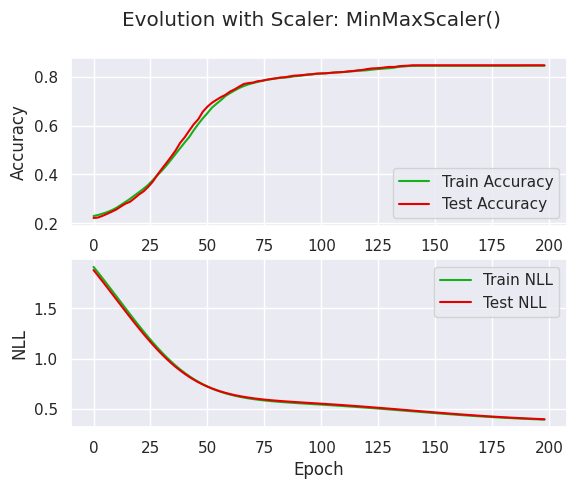

Acuratete folosind StandardScaler: 0.3337388483373885
Precision folosind StandardScaler: 0.06662134602311352
Recall folosind StandardScaler: 0.266304347826087
F1 Score folosind StandardScaler: 0.10657966286025013


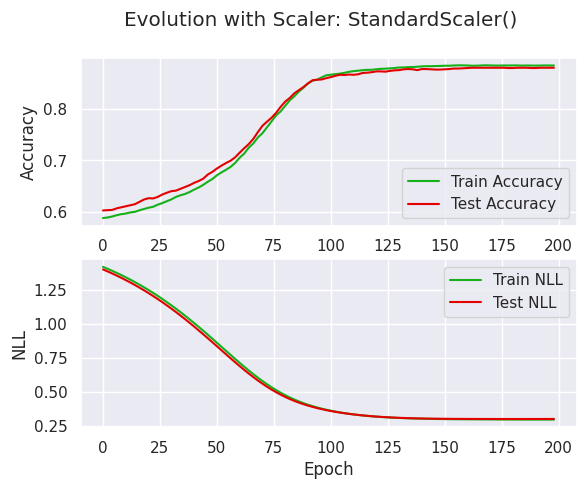

Acuratete folosind RobustScaler: 0.46958637469586373
Precision folosind RobustScaler: 0.03496503496503497
Recall folosind RobustScaler: 0.09283819628647215
F1 Score folosind RobustScaler: 0.050798258345428164


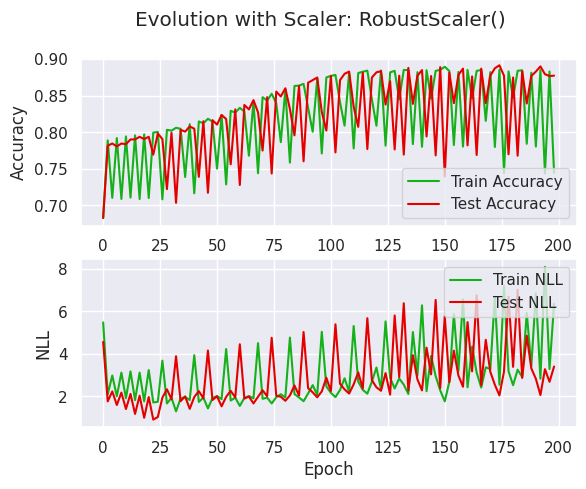

In [2446]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

#### Conclusion for the manual logistic regression

In [2447]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.7506082725060826
Median Accuracy: 0.7990673154906731
Variance Accuracy: 0.010024541386539005
Min Accuracy: 0.49635036496350365
Max Accuracy: 0.8438767234387672

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.3521086780210868
Median Accuracy: 0.33454987834549876
Variance Accuracy: 0.001321033369313334
Min Accuracy: 0.3175182481751825
Max Accuracy: 0.4233576642335766

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.5254663422546635
Median Accuracy: 0.47850770478507704
Variance Accuracy: 0.006835239878733583
Min Accuracy: 0.45944849959448497
Max Accuracy: 0.6723438767234388

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.1258680630298455
Median Precision: 0.10229303156640857
Variance Precision: 0.006039509035101878
Min Precision: 0.056818181818181816
Max Precision: 0.3333333333333333

Metrics for Precision

### 2. Implementare folosind scikit-learn

In [2448]:
def logistic_regression_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None, max_iter=5000)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [2449]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8771289537712895
Precision folosind MinMaxScaler: 0.7394366197183099
Recall folosind MinMaxScaler: 0.2830188679245283
F1 Score folosind MinMaxScaler: 0.4093567251461988
Acuratete folosind StandardScaler: 0.8925385239253852
Precision folosind StandardScaler: 0.776595744680851
Recall folosind StandardScaler: 0.3956639566395664
F1 Score folosind StandardScaler: 0.5242369838420108
Acuratete folosind RobustScaler: 0.894566098945661
Precision folosind RobustScaler: 0.7647058823529411
Recall folosind RobustScaler: 0.3983286908077994
F1 Score folosind RobustScaler: 0.5238095238095238

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8771289537712895
Precision folosind MinMaxScaler: 0.7913669064748201
Recall folosind MinMaxScaler: 0.2864583333333333
F1 Score folosind MinMaxScaler: 0.42065009560229444
Acuratete folosind StandardScaler: 0.8868613138686131
Precision folosind StandardScaler: 0.712041

#### Conclusion for the scikit-learn logistic regression

In [2450]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8735604217356043
Median Accuracy: 0.8753041362530414
Variance Accuracy: 1.8312307725702132e-05
Min Accuracy: 0.8645579886455799
Max Accuracy: 0.8779399837793999

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.8841038118410381
Median Accuracy: 0.8852392538523925
Variance Accuracy: 3.225702481567656e-05
Min Accuracy: 0.8759124087591241
Max Accuracy: 0.8925385239253852

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.8834549878345499
Median Accuracy: 0.8824006488240065
Variance Accuracy: 2.562670650119816e-05
Min Accuracy: 0.8767234387672344
Max Accuracy: 0.894566098945661

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.7604751683917446
Median Precision: 0.760459936186864
Variance Precision: 0.0009736958080528875
Min Precision: 0.7074829931972789
Max Precision: 0.8217054263565892

Metrics for Precision wit

## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

In [2451]:
def decision_tree_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the decision tree model
        model = DecisionTreeClassifier(random_state=None)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [2452]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    decision_tree_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8487429034874291
Precision folosind MinMaxScaler: 0.5367647058823529
Recall folosind MinMaxScaler: 0.543424317617866
F1 Score folosind MinMaxScaler: 0.5400739827373613
Acuratete folosind StandardScaler: 0.856853203568532
Precision folosind StandardScaler: 0.5542168674698795
Recall folosind StandardScaler: 0.5778894472361809
F1 Score folosind StandardScaler: 0.5658056580565806
Acuratete folosind RobustScaler: 0.8523925385239254
Precision folosind RobustScaler: 0.5024509803921569
Recall folosind RobustScaler: 0.5601092896174863
F1 Score folosind RobustScaler: 0.5297157622739018

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8584752635847527
Precision folosind MinMaxScaler: 0.5461741424802111
Recall folosind MinMaxScaler: 0.5390625
F1 Score folosind MinMaxScaler: 0.5425950196592398
Acuratete folosind StandardScaler: 0.862124898621249
Precision folosind StandardScaler: 0.5688775510204082


#### Conclusion for the scikit-learn logistic regression¶

In [2453]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8559205190592051
Median Accuracy: 0.8542173560421735
Variance Accuracy: 4.7262395505065014e-05
Min Accuracy: 0.8487429034874291
Max Accuracy: 0.8746958637469586

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.8609894566098945
Median Accuracy: 0.862124898621249
Variance Accuracy: 1.8180753790891104e-05
Min Accuracy: 0.851581508515815
Max Accuracy: 0.8673965936739659

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.8578264395782644
Median Accuracy: 0.8578669910786699
Variance Accuracy: 9.346907068327154e-06
Min Accuracy: 0.8523925385239254
Max Accuracy: 0.864963503649635

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.5414932199162599
Median Precision: 0.536900871459695
Variance Precision: 0.0006149898440952074
Min Precision: 0.5123762376237624
Max Precision: 0.608355091383812

Metrics for Precision with 

### 2. Implementare manuală